# LSQ fit applied to PSM sims 
### In this notebook, we will perform a simple end-to-end simulation, beginning by generating a log-normal field, transforming to redshift-space, adding Planck Sky Model foregrounds and noise, then removing the foregrounds, and estimating the power spectrum and correlation function. We can check to see if combining blind and parametric methods improves the H1 estimation. 

In [1]:
import numpy as np
import numpy.fft as fft
import pylab as plt
import pyccl as ccl
plt.rcParams["figure.figsize"] = (14,7)

In [2]:
import fastbox
from fastbox.box import CosmoBox, default_cosmo
from fastbox.psm_fgs import PSMfgModel
from fastbox.lsq_fit import LSQfitting
from fastbox.point_sources import PointSourceModel
from nbodykit.lab import ArrayMesh
from nbodykit.algorithms.fftcorr import FFTCorr
from nbodykit.algorithms.fftpower import FFTPower
import time, sys

In [3]:
np.random.seed(12)

## Generate simulation box
### Generate a Gaussian random realisation with a non-linear power spectrum on a (1 Gpc)^3 grid with 64^3 cells at redshift z=0.3. Then, paint biased HI onto the density field, apply a log-normal transformation, add linear and non-linear velocities to transform to redshift space, and finally rescale by the brightness temperature.

In [4]:
t0 = time.time()

# (1a) Generate Gaussian box (1 Gpc on each side, 64^3 grid, z=0.3)
box = CosmoBox(cosmo=default_cosmo, box_scale=(1e3,1e3,1e3), nsamp=64, 
               redshift=0.3, realise_now=False)
box.realise_density()

# (1b) Rescale tracer by bias [FIXME: Check this is being done in the right order]
tracer = fastbox.tracers.HITracer(box)
delta_hi = box.delta_x * tracer.bias_HI()

# (1c) Transform to a log-normal field
delta_ln = box.lognormal(delta_hi)

# (1d) Calculate radial velocity field (uses Gaussian density field; FIXME)
vel_k = box.realise_velocity(delta_x=box.delta_x, inplace=True)
vel_z = fft.ifftn(vel_k[2]).real # inverse FFT to get real-space radial velocity

# (1e) Transform to redshift space (also add non-linear velocity, sigma_nl=120 km/s)
delta_s = box.redshift_space_density(delta_x=delta_ln.real, velocity_z=vel_z, 
                                     sigma_nl=120., method='linear')

# (1f) Scale by mean brightness temperature (in mK), and include mean
signal_cube = tracer.signal_amplitude() * (1. + delta_s)

print("(1) Generating box complete (%3.3f sec)" % (time.time()-t0))

/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/pyccl/pk2d.py:198: RuntimeWarning: divide by zero encountered in log
  f, status = lib.pk2d_eval_multi(self.psp, np.log(k_use),
/Users/mirfan/Documents/FastBox/FastBox/fastbox/box.py:259: RuntimeWarning: invalid value encountered in true_divide
  Ax = 1.j * delta_k * self.Kx * (2.*np.pi/self.Lx) / k2
/Users/mirfan/Documents/FastBox/FastBox/fastbox/box.py:260: RuntimeWarning: invalid value encountered in true_divide
  Ay = 1.j * delta_k * self.Ky * (2.*np.pi/self.Ly) / k2
/Users/mirfan/Documents/FastBox/FastBox/fastbox/box.py:261: RuntimeWarning: invalid value encountered in true_divide
  Az = 1.j * delta_k * self.Kz * (2.*np.pi/self.Lz) / k2


(1) Generating box complete (0.693 sec)


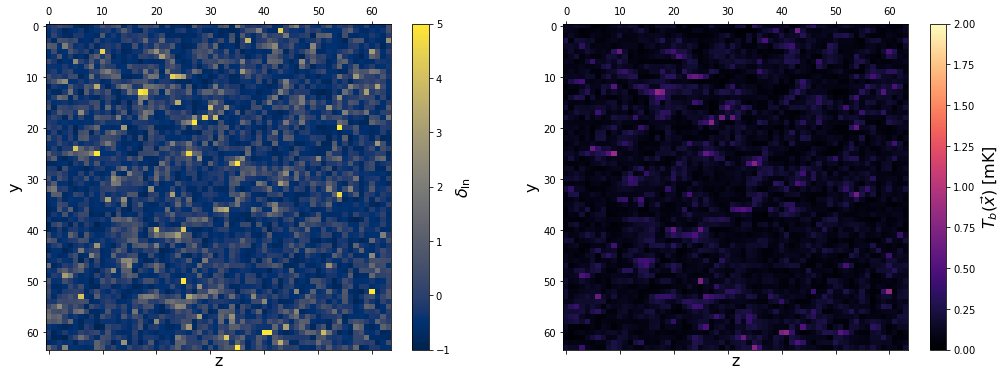

In [5]:
plt.subplot(121)
plt.matshow(delta_ln[10,:,:], vmin=-1., vmax=5., cmap='cividis', aspect='auto', fignum=False)
plt.xlabel("z", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$\delta_{\rm ln}$", fontsize=16)

plt.subplot(122)
plt.matshow(signal_cube[10,:,:], vmin=0., vmax=2., cmap='magma', aspect='auto', fignum=False)
plt.xlabel("z", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$T_b(\vec{x})$ [mK]", fontsize=16.)
plt.gcf().set_size_inches((17., 6.))

## Add foregrounds
### Use the Planck FFP10 simulations to create free-free and synchrotron maps and the Battye et al. 2012 model of point sources to create point source maps. 

In [6]:
t0 = time.time()

# Output frequency range
freqs = box.freq_array()
n_ch = len(freqs)
print("Frequency range: %3.1f -- %3.1f MHz\n" % (freqs[-1], freqs[0]))

# Angular pixels
ang_x, ang_y = box.pixel_array(redshift=box.redshift)
xside = len(ang_x)
yside = len(ang_y)

freeind = -2.1 #CHOOSE YOUR FREE-FREE SPECTRAL INDEX
psmmodel = PSMfgModel(box)
syncamp, freeamp, syncind = psmmodel.square_syncff(freqs[0], freeind)

# Apply spectral indices:
syncmap, freemap = np.zeros((xside,yside,n_ch)), np.zeros((xside,yside,n_ch))
for i in range(n_ch):
    syncmap[:,:,i] = syncamp * (freqs[i]/freqs[0])**(syncind)
    freemap[:,:,i] = freeamp * (freqs[i]/freqs[0])**(freeind)
    
#point sources
psaveind = -2.7 #CHOOSE YOUR PS PARAMETERS: average spectral index, index standard deviation and cut-off flux in Jy
cuttoff = 0.1
indspread = 0.2
psmodel = PointSourceModel(box)
psmap, tpsmean = psmodel.make_ps_nobeam(freqs, cuttoff, psaveind, indspread)

fg_cube = syncmap + freemap + psmap

print("(2) Adding foregrounds complete (%3.3f sec)" % (time.time()-t0))    

Frequency range: 980.0 -- 1205.2 MHz



/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))
/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-pack

(2) Adding foregrounds complete (31.604 sec)


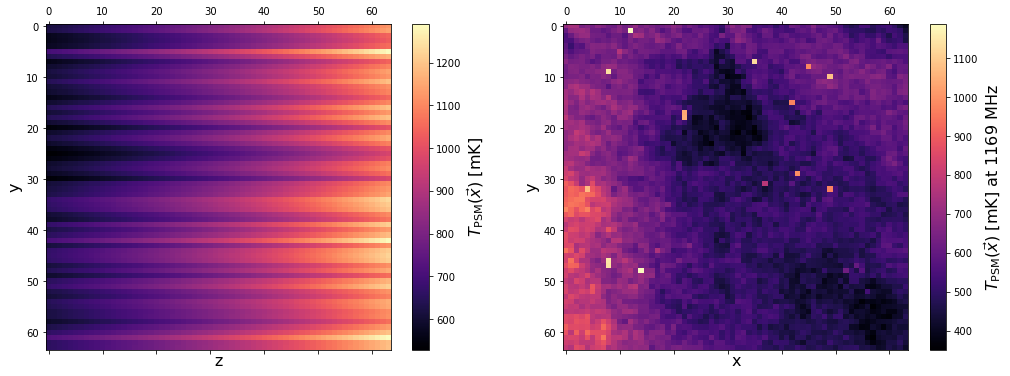

In [7]:
plt.subplot(121)
plt.matshow(fg_cube[10,:,:], cmap='magma', aspect='auto', fignum=False)
plt.xlabel("z", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$T_{\rm PSM}(\vec{x})$ [mK]", fontsize=16.)

plt.subplot(122)
plt.matshow(fg_cube[:,:,10].T, cmap='magma', aspect='auto', fignum=False)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$T_{\rm PSM}(\vec{x})$ [mK] at %d MHz" % (box.freq_array()[10]), fontsize=16.)
plt.gcf().set_size_inches((17., 6.))

## Add radiometer noise
### Adds a simple homogeneous white noise field for a MeerKAT-like multi-dish deep integration (64 dishes, 2 hours per pointing, assumed 1 degree FOV per pointing).

In [8]:
t0 = time.time()

# Generate homogeneous radiometer noise
noise_model = fastbox.noise.NoiseModel(box)
noise_cube = noise_model.realise_radiometer_noise(Tinst=18., tp=0.25, fov=1., Ndish=64)

print("(3) Adding noise complete (%3.3f sec)" % (time.time()-t0))

(3) Adding noise complete (0.007 sec)


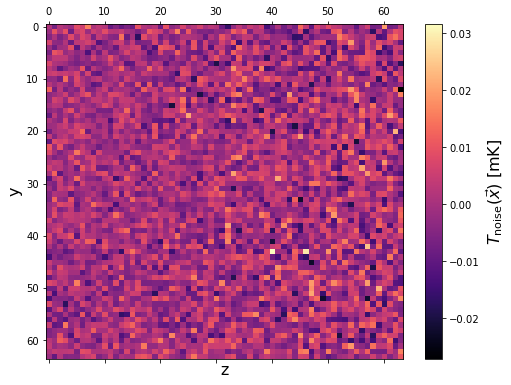

In [9]:
plt.matshow(noise_cube[10,:,:], cmap='magma', aspect='auto')
plt.xlabel("z", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$T_{\rm noise}(\vec{x})$ [mK]", fontsize=16.)
plt.gcf().set_size_inches((8., 6.))

## Construct final data cube (convolve with beam and add noise)

In [10]:
# Construct MeerKAT L-band beam
mkbeam = fastbox.beams.KatBeamModel(box, model='L')

In [11]:
# Convolve with beam
obs_cube = mkbeam.convolve_real(signal_cube + fg_cube, pol='I')
#obs_cube = mkbeam.convolve_fft(signal_cube + fg_cube, pol='I')

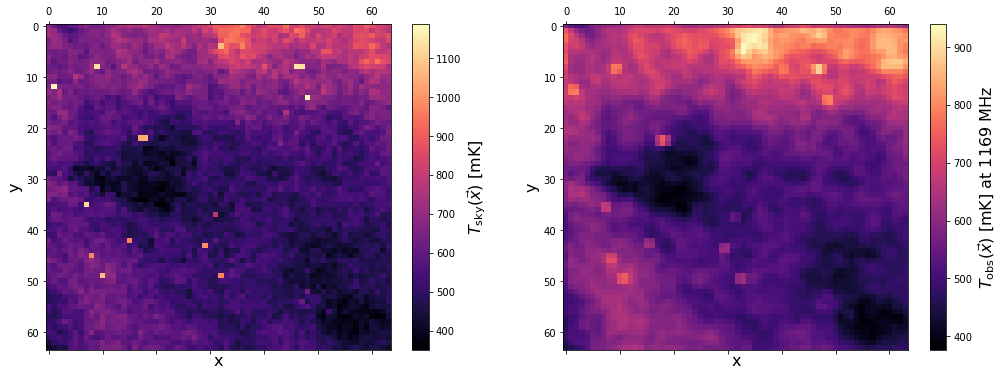

In [12]:
# Plot before and after beam convolution
plt.subplot(121)
plt.matshow((signal_cube + fg_cube)[:,:,10], cmap='magma', aspect='auto', fignum=False)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$T_{\rm sky}(\vec{x})$ [mK]", fontsize=16.)

plt.subplot(122)
plt.matshow(obs_cube[:,:,10], cmap='magma', aspect='auto', fignum=False)
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$T_{\rm obs}(\vec{x})$ [mK] at %d MHz" % (box.freq_array()[10]), fontsize=16.)
plt.gcf().set_size_inches((17., 6.))

In [13]:
# Combine beam-convolve observation and noise
data_cube = obs_cube + noise_cube

## Try several FG cleaning methods

running LSQ fit


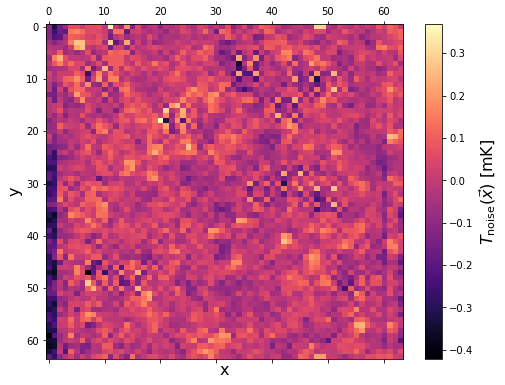

In [14]:
# LSQ fit uses sim information! I am assuming that we know the 
# the free-free spectral index and the point source behaviour 
paramfit = LSQfitting(box)
hest, syncindest = paramfit.give_hest(freqs, data_cube, freeind, psaveind, cuttoff, indspread)

plt.matshow(hest[:,:,10].T, cmap='magma', aspect='auto')
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
cbar = plt.colorbar()
cbar.set_label(label=r"$T_{\rm noise}(\vec{x})$ [mK]", fontsize=16.)
plt.gcf().set_size_inches((8., 6.))


In [15]:
#try kernal pca on full data and lsq resids
n = 3
cleaned_cube_kpca0, kpca_transform0 = fastbox.filters.kernel_pca_filter(data_cube, 
                                                                              nmodes=n, 
                                                                              gamma=1./(5.*n), ## FIXME
                                                                              return_filter=True, 
                                                                              kernel='sigmoid')
cleaned_cube_kpca, kpca_transform = fastbox.filters.kernel_pca_filter(hest, 
                                                                              nmodes=n, 
                                                                              gamma=1./(5.*n), ## FIXME
                                                                              return_filter=True, 
                                                                              kernel='sigmoid')

In [16]:
#try pca on full data and lsq resids
cleaned_cube0, U_fg0, amp_fg0 = fastbox.filters.pca_filter(data_cube, 
                                                         nmodes=3, 
                                                         return_filter=True)
cleaned_cube, U_fg, amp_fg = fastbox.filters.pca_filter(hest, 
                                                         nmodes=3, 
                                                         return_filter=True)

In [17]:
#try ica on full data and lsq resids
cleaned_cube_ica0, ica_transform0 = fastbox.filters.ica_filter(data_cube, 
                                                             nmodes=3, 
                                                             return_filter=True)
cleaned_cube_ica, ica_transform = fastbox.filters.ica_filter(hest, 
                                                             nmodes=3, 
                                                             return_filter=True)

## Calculate PS

In [18]:
# Subtract mean (as a function of frequency) from the data
mean_freq = np.mean(data_cube.reshape(-1, data_cube.shape[-1]), axis=0)
mean_sub_data = data_cube - mean_freq[np.newaxis,np.newaxis,:]

# Power spectra: input cosmo signal, data, FG-filtered data, theory
sig_k, sig_pk, sig_stddev = box.binned_power_spectrum(delta_x=signal_cube, nbins=50)
data_k, data_pk, data_stddev = box.binned_power_spectrum(delta_x=mean_sub_data, nbins=50)

proc_k0, proc_pk0, proc_stddev0 = box.binned_power_spectrum(delta_x=cleaned_cube0, nbins=50)
ica_k0, ica_pk0, ica_stddev0 = box.binned_power_spectrum(delta_x=cleaned_cube_ica0, nbins=50)
kpca_k0, kpca_pk0, kpca_stddev0 = box.binned_power_spectrum(delta_x=cleaned_cube_kpca0, nbins=50)


proc_k, proc_pk, proc_stddev = box.binned_power_spectrum(delta_x=cleaned_cube, nbins=50)
ica_k, ica_pk, ica_stddev = box.binned_power_spectrum(delta_x=cleaned_cube_ica, nbins=50)
kpca_k, kpca_pk, kpca_stddev = box.binned_power_spectrum(delta_x=cleaned_cube_kpca, nbins=50)

th_k, th_pk = box.theoretical_power_spectrum()

/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/opt/anaconda3/envs/env_fastbox/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Amplitude factor for theoretical spectrum


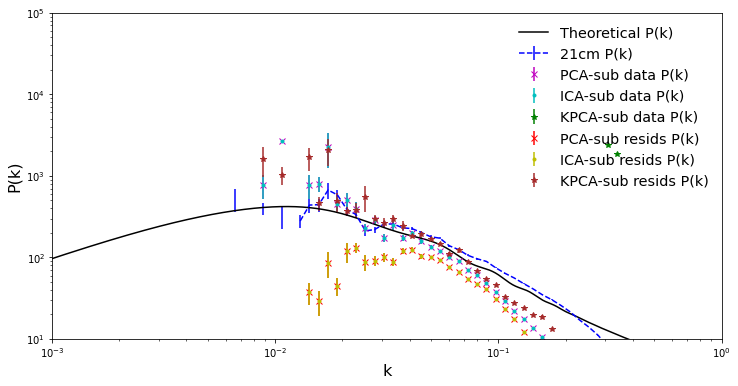

In [19]:
print("Amplitude factor for theoretical spectrum")
amp_fac = (tracer.signal_amplitude() * tracer.bias_HI())**2. # FIXME: No RSD contrib.

# Plot power spectra
plt.subplot(111)
plt.plot(th_k, th_pk * amp_fac, 'k-', label="Theoretical P(k)")
plt.errorbar(sig_k, sig_pk, yerr=sig_stddev, color='b', ls='dashed', label="21cm P(k)")

plt.errorbar(proc_k0, proc_pk0, yerr=proc_stddev0, color='m', marker='x', ls='none',label="PCA-sub data P(k)")
plt.errorbar(ica_k0, ica_pk0, yerr=ica_stddev0, color='c', marker='.', ls='none', label="ICA-sub data P(k)")
plt.errorbar(kpca_k0, kpca_pk0, yerr=kpca_stddev0, color='g', marker='*', ls='none', label="KPCA-sub data P(k)")
plt.errorbar(proc_k, proc_pk, yerr=proc_stddev, color='r', marker='x', ls='none', label="PCA-sub resids P(k)")
plt.errorbar(ica_k, ica_pk, yerr=ica_stddev, color='y', marker='.', ls='none', label="ICA-sub resids P(k)")
plt.errorbar(kpca_k, kpca_pk, yerr=kpca_stddev, color='brown', marker='*', ls='none', label="KPCA-sub resids P(k)")

plt.legend(loc='upper right', frameon=False, prop={'size':'x-large'})
plt.xlim((1e-3, 1e0))
plt.ylim((1e1, 1e5))
plt.xscale('log')
plt.yscale('log')
plt.xlabel("k", size=16)
plt.ylabel("P(k)", size=16)

plt.gcf().set_size_inches((12., 6.))
plt.show()
